In [35]:
import numpy as np

def min_max_normalize_dict(data_dict):
    """
    Min-Max normalize the values of a dictionary.

    If all values are the same or the dictionary is empty, 
    it returns a dictionary with zeros as values.

    Parameters:
        data_dict (dict): A dictionary with numeric values.

    Returns:
        dict: A new dictionary with normalized values in [0, 1].
    """
    # Handle the empty dictionary case
    if not data_dict:
        return {}

    # Convert dict values to a NumPy array
    values = np.array(list(data_dict.values()), dtype=float)

    val_min = values.min()
    val_max = values.max()

    # If all values are the same, return zeros
    if val_min == val_max:
        return {k: 0.0 for k in data_dict}

    # Perform min-max normalization
    normalized_values = (values - val_min) / (val_max - val_min)

    # Reconstruct dictionary
    normalized_dict = dict(zip(data_dict.keys(), normalized_values))

    return normalized_dict

Urgency at bucket 1 = 0.20000000000000004
  Agent A: score=-0.76
  Agent N: score=-0.25
  Agent P: score=0.01
[Bucket 1] Updated fill_rates for bucket 2: {'A': 0.99, 'N': 0.5, 'P': 0.226430956506547}
[Bucket 1] chose agent=P, posted=2000.0, fill=405.7, cost=0.3, reward=-0.3
Urgency at bucket 2 = 0.30391414260960725
  Agent A: score=0.12
  Agent N: score=0.46
  Agent P: score=0.03
[Bucket 2] Updated fill_rates for bucket 3: {'A': 0.99, 'N': 0.49183108473152204, 'P': 0.25}
[Bucket 2] chose agent=N, posted=3594.3, fill=1738.4, cost=0.1, reward=-0.1
Urgency at bucket 3 = 0.46474481016027075
  Agent A: score=0.28
  Agent N: score=0.29
  Agent P: score=0.07
[Bucket 3] Updated fill_rates for bucket 4: {'A': 0.99, 'N': 0.5140712112843134, 'P': 0.25}
[Bucket 3] chose agent=N, posted=4855.9, fill=2604.3, cost=0.0, reward=-0.0
Urgency at bucket 4 = 0.6925160758039051
  Agent A: score=0.55
  Agent N: score=0.37
  Agent P: score=0.14
[Bucket 4] chose agent=A, posted=4251.6, fill=4251.6, cost=0.4, r

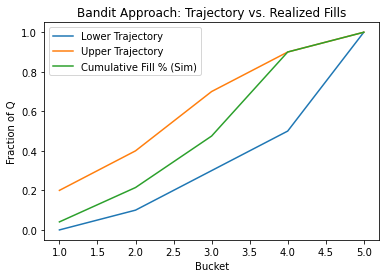

In [105]:
import random
import math
import matplotlib.pyplot as plt

def bandit_trading_epsilon_greedy(
    B,             # number of buckets
    Q,             # total shares to fill by final bucket
    L, U,          # arrays of length B+1 with L[b], U[b] in [0..1], giving corridor fractions
    fill_rates,    # dict(b -> {'A':..., 'N':..., 'P':...}) predicted fill fraction each bucket
    cost_dict,     # cost per share for each agent, e.g. {'A':2, 'N':1, 'P':0}
    remaining_volume,
    epsilon_init=0.0,   # initial epsilon
    epsilon_decay=0.00, # how much to reduce epsilon each bucket
    verbose=True
):
    """
    Demonstrates a simple multi-armed bandit approach (epsilon-greedy) 
    for picking which agent (A, N, P) to use each bucket, 
    and a heuristic for how many shares to post each bucket 
    so we stay in the [L(b)*Q, U(b)*Q] corridor.

    B, Q, L, U: as described above
    fill_rates[b]['A'] in [0..1], etc.
    cost_dict = {'A':2, 'N':1, 'P':0} cost per share

    Returns:
       A dictionary with:
         - 'allocations': which agent & how many shares posted in each bucket
         - 'realized_fills': how many shares actually filled
         - 'cumulative_fill': the total fill after each bucket
         - 'agent_values': final Q-value estimate for each agent
         - 'final_status'
         - 'trajectory_data': for plotting
    """

    # We'll keep track of each agent's estimated Q-value (bandit value),
    # and how many times we've chosen that agent.
    agents = ['A','N','P']
    #Q_value = {agent: 0.0 for agent in agents}  # average reward estimate
    Q_value = {'A': 0.0, 'N': 0.0, 'P': 0.0}
    count_arms = {agent: 0 for agent in agents}  # how many times chosen

    # We'll define "reward" as negative cost per fill, or something like that.
    # Another approach is reward = fill / cost, etc. Let's pick:
    # reward = - (cost_of_bucket)  (so bigger = better if cost is negative)
    # but we also want to ensure we actually get a fill. We'll do a simple example below.

    # We'll store final results for each bucket
    bucket_alloc = {b: {'agent': None, 'shares_posted': 0} for b in range(1,B+1)}
    bucket_fill  = {b: 0.0 for b in range(1,B+1)}
    cumulative_fill = 0.0
    
    # for fill rate update
    alpha_update = 0.5 
    
    # For plotting or analysis
    lower_line = []
    upper_line = []
    cum_line   = []
    realized_line = []

    def urgency(b, B, Q, fill_so_far, remaining_volume_b, alpha=1.0, beta=0.0):
        """
        b: current bucket (1..B)
        B: total number of buckets
        Q: total shares
        fill_so_far: how many shares we've already filled
        remaining_volume_b: predicted remaining market volume from b..B
        alpha, beta: weighting parameters
        """
        # Time factor:
        if beta <= 0.0:
            # linear approach
            time_factor = b / B
        else:
            # exponential approach
            time_factor = math.exp(beta * (b/B))

        # Volume factor:
        shares_left = Q - fill_so_far
        if remaining_volume_b <= 0:
            # avoid divide by 0
            volume_factor = 1.0  # extremely urgent if no volume
        else:
            volume_factor = shares_left / remaining_volume_b

        return alpha * (((b/B)* time_factor) + ((1-b/B) * volume_factor))

    def agent_score(b, B, agent, fill_rates, Q_value, cost_dict, urgency):
        """
        agent: e.g. 'A','N','P'
        fill_rate: predicted fill rate for this agent in the current bucket
        cost: cost for this agent
        urgency: the urgency for this bucket
        """
        # Example: Score = (fill_rate * urgency) + reward
        n_Q_value = min_max_normalize_dict(Q_value)
        n_cost_dict = min_max_normalize_dict(cost_dict)
        #print(f" Q: {n_Q_value}")
        return (b/B)*fill_rates[b][agent] * urgency + (1-b/B)*n_Q_value[agent] - (1-b/B)*n_cost_dict[agent]

    def deviation_penalty(actual_shares, target_shares, alpha=1.0):
        """
        Computes a penalty = alpha * |actual_shares - target_shares|.
        """
        if (target_shares == 0):
            return 0.0
        
        dev = abs(actual_shares - target_shares) / target_shares
        return alpha * dev

    def cost_function(agent, actual_shares, cost_dict, target_shares, alpha):
        """
        Example cost = (trading cost) + penalty for deviating from target.
        """
        trading_cost = cost_dict[agent] * actual_shares
        penalty = deviation_penalty(actual_shares, target_shares, alpha)
        return penalty

    # We define a helper to clamp within corridor
    def clamp_bucket_shares(b, cum_fill_before):
        """
        Figure out how many shares we should post in bucket b so that 
        after bucket b we remain within [L(b)*Q, U(b)*Q].
        We'll pick something in the feasible range. 
        If there's no feasible range, we might do 0 or do the best we can.
        """
        # The min cumulative fill we need by bucket b is L[b]*Q
        min_req = L[b]*Q
        max_req = U[b]*Q

        # How many we've already filled so far:
        already = cum_fill_before

        # We want the final fill after bucket b to be in [min_req, max_req].
        # The fill we get in bucket b depends on the agent's fill rate,
        # but we haven't picked the agent yet. Let's guess we might get ~some average fill rate?
        # For simplicity, let's guess an average fill rate. 
        # Alternatively, we can just pick a default chunk.
        
        # We'll do a simpler approach: 
        # We'll plan to post the difference between some "target" in the corridor 
        # and what we have so far. Let's pick the midpoint of the corridor for bucket b:
        midpoint = 0.5*(min_req + max_req)
        # If already >= max_req, we can't post more or we'd exceed corridor. 
        # If already <= min_req, we might want to post enough to reach midpoint, etc.
        
        #needed = midpoint - already
        needed = max_req - already
        if needed < 0.0:
            # We are already above midpoint. We might still post 0 shares to avoid overshooting
            return 0.0
        # But we can't exceed Q total in theory if we want final fill=Q. 
        # We'll keep it simple. Just return needed. 
        # We'll let the actual fill fraction decide how many we actually fill.

        return max(0.0, needed)  # can't be negative

    # We'll define an epsilon schedule
    def epsilon_func(b):
        # e.g. starts at epsilon_init, decays by epsilon_decay each bucket
        # never below 0
        return max(0.0, epsilon_init - (b-1)*epsilon_decay)

    # ---------- MAIN LOOP -------------
    for b in range(1, B+1):
        # 1) figure out how many shares we want to post this bucket to stay near corridor
        shares_to_post = clamp_bucket_shares(b, cumulative_fill)

        # If shares_to_post is extremely small, we might set it to 0 and skip
        if shares_to_post < 1e-9:
            # post 0 shares, no fill, move on
            bucket_alloc[b]['agent'] = None
            bucket_alloc[b]['shares_posted'] = 0
            bucket_fill[b] = 0.0
            if verbose:
                print(f"[Bucket {b}] skipping (0 shares). Already at corridor: cum_fill={cumulative_fill:.1f}")
        else:
            # 2) pick an agent via epsilon-greedy
            eps_b = epsilon_func(b)
            # Explore?
            if random.random() < eps_b:
                chosen_agent = random.choice(agents)
            else:
                # Exploit: choose agent with highest Q_value
                chosen_agent = max(agents, key=lambda a: Q_value[a])
                
                urg = urgency(b, B, Q, cumulative_fill, remaining_volume[b], alpha=1.0, beta=0.0)
                print(f"Urgency at bucket {b} =", urg)
                best_score = float('-inf')
                for ag in agents:
                    s = agent_score(b, B, ag, fill_rates, Q_value, cost_dict, urg)
                    print(f"  Agent {ag}: score={s:.2f}")
                    if s > best_score:
                        best_score = s
                        chosen_agent = ag

            # 3) "Execute": we pay cost = cost_dict[chosen_agent]*shares_to_post
            #    We get fill fraction = fill_rates[b][chosen_agent], plus some noise
            #    We'll do a small random shock:
            base_frac = fill_rates[b][chosen_agent]
            actual_frac = max(0.0, min(1.0, base_frac + 0.1*(random.random()-0.5)))
            actual_fill = shares_to_post * actual_frac

            # --------------------------------------------
            # 3.5) Update fill rates for bucket b+1 using actual fill fraction
            # --------------------------------------------
            if b < B-1:
                new_rate = alpha_update*actual_frac + (1-alpha_update)*base_frac
                new_rate = max(0.0, min(1.0, new_rate))
                fill_rates[b+1][chosen_agent] = new_rate
                if verbose:
                    print(f"[Bucket {b}] Updated fill_rates for bucket {b+1}: {fill_rates[b+1]}")
                
            # 4) compute reward, e.g. reward = - total cost
            target_shares = 0.5*(L[b]*Q + U[b]*Q)
            total_cost = cost_function(chosen_agent, actual_fill, cost_dict, target_shares-cumulative_fill, 0.5)
            #total_cost = cost_dict[chosen_agent]*shares_to_post
            reward = -total_cost  # a bigger reward => smaller cost => good

            # 5) update bandit Q-value
            count_arms[chosen_agent] += 1
            n = count_arms[chosen_agent]
            old_Q = Q_value[chosen_agent]
            new_Q = old_Q + (reward - old_Q)/n
            Q_value[chosen_agent] = new_Q

            # 6) record the results
            bucket_alloc[b]['agent'] = chosen_agent
            bucket_alloc[b]['shares_posted'] = shares_to_post
            bucket_fill[b] = actual_fill
            # update cumulative fill
            cumulative_fill += actual_fill

            if verbose:
                print(f"[Bucket {b}] chose agent={chosen_agent}, posted={shares_to_post:.1f}, fill={actual_fill:.1f}, cost={total_cost:.1f}, reward={reward:.1f}")

        # for plotting
        lower_line.append(L[b])
        upper_line.append(U[b])
        cum_line.append(cumulative_fill/Q)   # fraction
        realized_line.append(cumulative_fill/Q)

    final_status = "Completed"
    if cumulative_fill < Q - 1e-6:
        final_status = "DidNotFillAll"

    results = {
        'allocations': bucket_alloc,
        'realized_fills': bucket_fill,
        'cumulative_fill': cum_line,
        'agent_values': Q_value,
        'final_status': final_status,
        'trajectory_data': {
            'buckets': list(range(1,B+1)),
            'lower_line': lower_line,
            'upper_line': upper_line,
            'cum_line': cum_line,
            'realized_line': realized_line
        }
    }
    return results


# ---------------------------
# DEMO MAIN
# ---------------------------
if __name__ == "__main__":
    # Example parameters
    B = 5
    Q = 10000

    # Trajectory constraints: L[b], U[b] from b=1..B (1-indexed)
    #L = [0, 0.0, 0.1, 0.3, 0.5, 1.0]  # b=1 => 0.., b=5 => 1.0
    #U = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    L = [0, 0.0, 0.1, 0.3, 0.5, 1.0]
    U = [0, 0.2, 0.4, 0.7, 0.9, 1.0]
    
    remaining_volume = [60000.0, 50000.0, 40000.0, 30000.0, 20000.0, 10000.0]
    
    # Fill rates for each agent in each bucket
    fill_rates = {
        1: {'A':0.99, 'N':0.5,  'P':0.25},
        2: {'A':0.99, 'N':0.5,  'P':0.25},
        3: {'A':0.99, 'N':0.48, 'P':0.25},
        4: {'A':0.99, 'N':0.50, 'P':0.25},
        5: {'A':1.00, 'N':0.50, 'P':0.25},
    }

    # Costs per share
    cost_dict = {'A': 3, 'N': 1, 'P': 0}

    # Run the bandit approach
    results = bandit_trading_epsilon_greedy(
        B=B,
        Q=Q,
        L=L,
        U=U,
        fill_rates=fill_rates,
        cost_dict=cost_dict,
        remaining_volume=remaining_volume,
        epsilon_init=0.30,
        epsilon_decay=0.08,
        verbose=True
    )

    print("\n==== Final Results ====")
    print("Status:", results['final_status'])
    print("Agent Q-values:", results['agent_values'])
    for b in range(1,B+1):
        agent = results['allocations'][b]['agent']
        posted = results['allocations'][b]['shares_posted']
        filled = results['realized_fills'][b]
        print(f"Bucket {b}: agent={agent}, posted={posted:.1f}, fill={filled:.1f}")

    # -----------
    # PLOT
    # -----------
    data = results['trajectory_data']
    buckets = data['buckets']

    plt.plot(buckets, data['lower_line'], label='Lower Trajectory')
    plt.plot(buckets, data['upper_line'], label='Upper Trajectory')
    plt.plot(buckets, data['cum_line'],  label='Cumulative Fill % (Sim)')
    plt.xlabel("Bucket")
    plt.ylabel("Fraction of Q")
    plt.title("Bandit Approach: Trajectory vs. Realized Fills")
    plt.legend()
    plt.show()
